In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.lines import Line2D
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, KFold, cross_val_predict
from sklearn.metrics import roc_curve, auc, roc_auc_score, plot_roc_curve, confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay, classification_report, RocCurveDisplay
from sklearn.model_selection import StratifiedKFold

<font size="5">     <b>I. Classification</b>

<font size="4">    <b>Loading the data</b>

<font size="3" color='blue'>    <b>Offset correction for EMG -> +0.28 on Biceps</b>

In [22]:
pID = '11'

path = "/Users/willy/Documents/GitHub/2021-fastReach/data/study/eeglab2python/"

# 0.1s
data_eeg_name_01 = '\data_s11_rp-win_-0.1-0_srate-250_modality-eeg.csv'
data_emg_name_01 = '\data_s11_rp-win_-0.1-0_srate-250_modality-emg.csv'
data_eye_name_01 = '\data_s11_rp-win_-0.1-0_srate-250_modality-eye.csv'

data_eeg_01 = pd.read_csv(path+pID+data_eeg_name_01)
data_remg_01 = pd.read_csv(path+pID+data_emg_name_01)
data_emg_01 = pd.concat([data_remg_01.iloc[:,:3], data_remg_01.iloc[:,3]-0.009, data_remg_01.iloc[:,4] + 0.270], axis=1)
data_emg_01.rename(columns={'EMG1':'Deltoïd', 'EMG2':'Biceps'}, inplace=True )
data_eye_01 = pd.read_csv(path+pID+data_eye_name_01)

# 1s
data_eeg_name_1 = '\data_s11_rp-win_-1-0_srate-250_modality-eeg.csv'
data_emg_name_1 = '\data_s11_rp-win_-1-0_srate-250_modality-emg.csv'
data_eye_name_1 = '\data_s11_rp-win_-1-0_srate-250_modality-eye.csv'

data_eeg_1 = pd.read_csv(path+pID+data_eeg_name_1)
data_remg_1 = pd.read_csv(path+pID+data_emg_name_1)
data_emg_1 = pd.concat([data_remg_1.iloc[:,:3], data_remg_1.iloc[:,3]-0.009, data_remg_1.iloc[:,4] + 0.270], axis=1)
data_emg_1.rename(columns={'EMG1':'Deltoïd', 'EMG2':'Biceps'}, inplace=True )
data_eye_1 = pd.read_csv(path+pID+data_eye_name_1)

#Choose the data set to use, classifier EEG-EMG will only work if both modalities are on the safe timeframe
data_eeg = data_eeg_1
data_emg = data_emg_1
data_eye = data_eye_1



In [23]:
# Get the EEG on [-0.4 0]
data_eeg_1 = np.zeros((len(data_eeg)//2, data_eeg.shape[1]))

for i in range(max(data_eeg['epoch_ix'])):
    data_eeg_1[125*i:125+125*i, :] = data_eeg.iloc[125+250*i:250+250*i, :]

In [24]:
data_eeg_1_11 = pd.DataFrame(data_eeg_1, columns=data_eeg.columns)
data_eeg_1_11

,sample,epoch_ix,rp_class,FC1,C2,Cz,TP9,FCz,Fp2,CP5,...,C3,C4,F4,AF4,TP10,P5,PO3,F6,CP2,PO7
0,-0.496,1.0,1.0,11.412494,13.612501,15.112499,-14.587502,17.312500,-15.387487,-3.787510,...,0.312502,16.312510,11.312496,-5.187504,-8.987501,-3.387491,-5.087496,8.812504,7.012506,-4.587494
1,-0.492,1.0,1.0,12.568741,12.968754,16.368748,-14.931246,17.168751,-15.231245,-3.931269,...,1.468740,15.768754,10.868748,-5.431255,-8.631250,-3.531242,-4.131239,9.968756,8.468748,-6.031241
2,-0.488,1.0,1.0,10.503118,12.703123,15.103123,-10.396870,16.103123,-14.696865,-4.596886,...,0.603113,15.203120,9.103119,-3.996883,-10.096880,-4.496868,-2.796871,12.903127,6.703123,-8.096868
3,-0.484,1.0,1.0,7.951557,11.451572,13.051563,-12.448433,13.851570,-14.948431,-6.248459,...,-1.048454,15.751546,7.851562,-3.948433,-5.148434,-3.848433,-1.748432,15.051573,5.951565,-8.048432
4,-0.480,1.0,1.0,8.170301,11.870317,12.270306,-10.529688,13.370312,-21.129679,-5.629686,...,0.370321,15.570315,8.270311,-7.529690,-2.629684,-1.729680,-2.929678,14.770319,7.470314,-6.429677
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33745,-0.016,270.0,2.0,-9.089063,15.010939,6.910940,5.010949,6.310936,24.310949,-12.189062,...,-10.889066,12.610935,33.510943,30.310935,26.510949,-12.289055,6.010937,44.310934,11.910940,-15.989063
33746,-0.012,270.0,2.0,-9.293752,15.606253,6.006252,6.306241,5.006252,20.106279,-12.393762,...,-10.393749,13.906240,31.206252,28.706251,24.206239,-9.593749,9.806250,41.506251,14.906254,-12.093754
33747,-0.008,270.0,2.0,-9.504685,15.095312,5.495314,1.395316,4.795307,18.295313,-13.304689,...,-10.304691,12.895310,30.195317,27.595306,28.795308,-9.604686,6.295311,41.295307,13.495314,-13.504689
33748,-0.004,270.0,2.0,-8.924994,14.575003,4.375008,-5.025003,5.574997,15.974997,-12.724998,...,-10.024998,12.975000,27.975005,25.774999,31.174993,-10.524990,5.974998,38.875001,13.475003,-14.624991


In [25]:
# Define the window size on which we will extract the features
# EEG Window 
win_eeg = 25
win_eeg_scaled = np.arange(len(data_eeg_1_11))//win_eeg

# EMG Window 
win_emg = 250
win_emg_scaled = np.arange(len(data_emg))//win_emg

# EYE Window 
win_eye = 100
win_eye_scaled = np.arange(len(data_eye))//win_eye

<font size="4">    <b>Epoch representation, Highlight when the 2 classes are significatively differents ??</b>

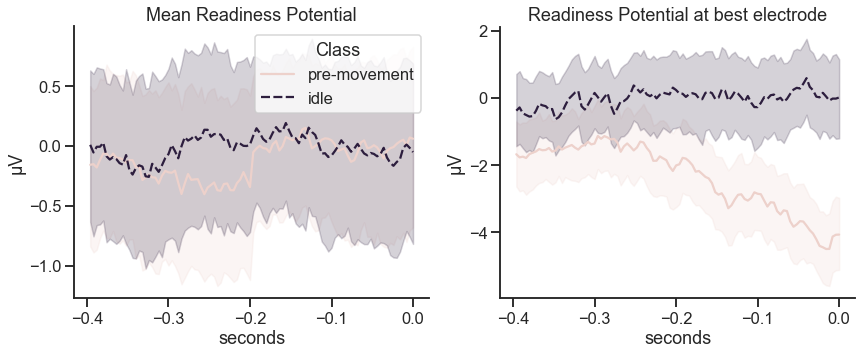

In [13]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(14,5))

sns.set_theme(style="ticks")
sns.set_context("talk")

electrodes = data_eeg.iloc[:,3:].mean(axis=1)
electrode = 'FCz'

# Plot the responses for different events and regions
g = sns.lineplot(ax=axes[0], x="sample", y=electrodes,
             hue="rp_class", style="rp_class",
             data=data_eeg_1_11)
sns.despine()
g.set(xlabel='seconds', ylabel='\u03bcV', title='Mean Readiness Potential')

g2 = sns.lineplot(ax=axes[1], x="sample", y=electrode,
             hue="rp_class", style="rp_class",
             data=data_eeg_1_11, legend=False)
g2.set(xlabel='seconds', ylabel='\u03bcV', title='Readiness Potential at best electrode')

# legend
leg = g.legend_
new_title = 'Class'
leg.set_title(new_title)
# replace labels
new_labels = ['pre-movement', 'idle']
for t, l in zip(g.legend_.texts, new_labels):
    t.set_text(l)

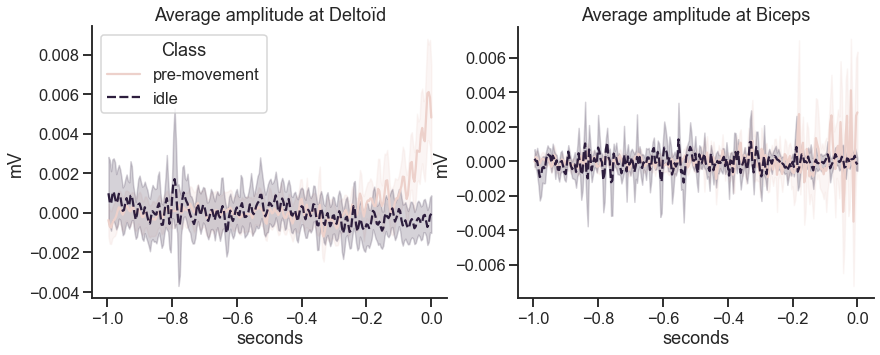

In [240]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(14,5))

sns.set_theme(style="ticks")
sns.set_context("talk")


electrode1 = 'Deltoïd'
electrode2 = 'Biceps'

# Plot the responses for different events and regions
g = sns.lineplot(ax=axes[0], x="sample", y=electrode1,
             hue="rp_class", style="rp_class",
             data=data_emg)
sns.despine()
g.set(xlabel='seconds', ylabel='mV', title='Average amplitude at '+ electrode1)

g2 = sns.lineplot(ax=axes[1], x="sample", y=electrode2,
             hue="rp_class", style="rp_class",
             data=data_emg, legend=False)
g2.set(xlabel='seconds', ylabel='mV', title='Average amplitude at '+ electrode2)

# legend
leg = g.legend_
new_title = 'Class'
leg.set_title(new_title)
# replace labels
new_labels = ['pre-movement', 'idle']
for t, l in zip(g.legend_.texts, new_labels):
    t.set_text(l)

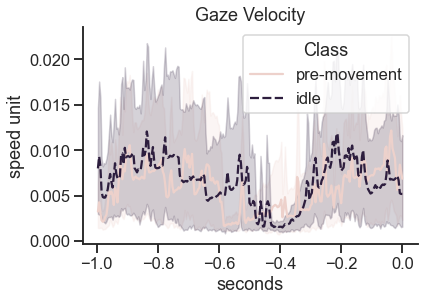

In [6]:
sns.set_theme(style="ticks")
sns.set_context("talk")

# Plot the responses for different events and regions
g = sns.lineplot(x="sample", y='GazeVel',
             hue="rp_class", style="rp_class",
             data=data_eye)
sns.despine()
g.set(xlabel='seconds', ylabel='speed unit', title='Gaze Velocity')

# legend
leg = g.legend_
new_title = 'Class'
leg.set_title(new_title)
# replace labels
new_labels = ['pre-movement', 'idle']
for t, l in zip(g.legend_.texts, new_labels):
    t.set_text(l)

<font size="4">    <b>Clean feature definitions</b>

In [14]:
def rms(values):
    return np.sqrt(sum(values**2)/len(values))

def mini(values):
    return np.min(values)

def maxi(values):
    return np.max(values)

def mav(values):
    return np.mean(abs(values))

def var(values):
    return np.var(values)

<font size="4">    <b>Not clean feature extraction</b>

In [8]:
#Waveform length
wl_1 = np.zeros((len(data_emg['Biceps'])//win_emg))
b = np.zeros((win_emg))
wl_2 = np.zeros((len(data_emg['Deltoïd'])//win_emg))
c = np.zeros((win_emg))

for j in range(len(data_emg['Biceps'])//win_emg):
    wl_1[j] = np.sum(b)
    wl_2[j] = np.sum(c)
    
    for i in range(win_emg):
        b[i] = abs(data_emg['Biceps'][(i+1)+j] - data_emg['Biceps'][i+j])
        c[i] = abs(data_emg['Deltoïd'][(i+1)+j] - data_emg['Deltoïd'][i+j])
        
#Mean absolute value slope
d_1 = data_emg.groupby(win_emg_scaled)['Biceps'].apply(mav)
mavs_1 = np.zeros((len(data_emg['Biceps'])//win_emg))
d_2 = data_emg.groupby(win_emg_scaled)['Deltoïd'].apply(mav)
mavs_2 = np.zeros((len(data_emg['Deltoïd'])//win_emg))

for i in range((len(data_emg['Biceps'])//win_emg)-1):
    mavs_1[i] = d_1[i+1] - d_1[i]
    mavs_2[i] = d_2[i+1] - d_2[i]   

In [9]:
#Zero crossing
z_1 = np.zeros((len(data_emg['Biceps'])//win_emg))
z_2 = np.zeros((len(data_emg['Biceps'])//win_emg))

for j in range(len(data_emg['Biceps'])//win_emg):
    
    for i in range(win_emg):
        if data_emg['Biceps'][i+j] > 0 and data_emg['Biceps'][(i+1)+j] < 0 and abs(data_emg['Biceps'][i+j]-data_emg['Biceps'][(i+1)+j]) > 0.002:
            z_1[j] += 1
        elif data_emg['Biceps'][i+j] < 0 and data_emg['Biceps'][(i+1)+j] > 0 and abs(data_emg['Biceps'][i+j]-data_emg['Biceps'][(i+1)+j]) > 0.002:
            z_1[j] += 1
        else:
            z_1[j] += 0

        if data_emg['Deltoïd'][i+j]>0 and data_emg['Deltoïd'][(i+1)+j]<0 and abs(data_emg['Deltoïd'][i+j]-data_emg['Deltoïd'][(i+1)+j]) > 0.002:
            z_2[j] += 1
        elif data_emg['Deltoïd'][i+j]<0 and data_emg['Deltoïd'][(i+1)+j]>0 and abs(data_emg['Deltoïd'][i+j]-data_emg['Deltoïd'][(i+1)+j]) > 0.002:
            z_2[j] += 1
        else:
            z_2[j] += 0

In [10]:
#Slope sign change
ss_1 = np.zeros((len(data_emg['Biceps'])//win_emg))
ss_2 = np.zeros((len(data_emg['Biceps'])//win_emg))

for j in range(len(data_emg['Biceps'])//win_emg):
    
    for i in range(1,win_emg):
        if data_emg['Biceps'][i+j] > data_emg['Biceps'][(i-1)+j] and data_emg['Biceps'][i+j] > data_emg['Biceps'][(i+1)+j] and abs(data_emg['Biceps'][i+j]-data_emg['Biceps'][(i+1)+j]) > 0.002:
            ss_1 += 1
        elif data_emg['Biceps'][i+j] < data_emg['Biceps'][(i-1)+j] and data_emg['Biceps'][i+j] < data_emg['Biceps'][(i+1)+j] and abs(data_emg['Biceps'][i+j]-data_emg['Biceps'][(i+1)+j]) > 0.002:
            ss_1 += 1
        else:
            ss_1 += 0
        
        if data_emg['Deltoïd'][i+j] > data_emg['Deltoïd'][(i-1)+j] and data_emg['Deltoïd'][i+j] > data_emg['Deltoïd'][(i+1)+j] and abs(data_emg['Biceps'][i+j]-data_emg['Biceps'][(i+1)+j]) > 0.002:
            ss_2 += 1
        elif data_emg['Deltoïd'][i+j] < data_emg['Deltoïd'][(i-1)+j] and data_emg['Deltoïd'][i+j] < data_emg['Deltoïd'][(i+1)+j] and abs(data_emg['Biceps'][i+j]-data_emg['Biceps'][(i+1)+j]) > 0.002:
            ss_2 += 1
        else:
            ss_2 += 0

<font size="4">    <b>Feature extraction</b>
    
EEG: We want to extract 1 feature (mean) at each window having a size of 25 samples, so 10 times per epoch or per second.
    
    -> 10 features per epoch per channel.

EMG: We want to extract X features (5 ? See if selection) at each window having a size of 100 samples, so 10 times per epoch or per seconds.
    
    ->10 features per epoch per channel (better do features on win_size 25 ? so 40 features per epoch per channel).

In [26]:
# Write the features list we want to use for the EMG data.
feat_list = [rms, mini, maxi, mav, var]                                        #list for apply groupby
nfeat_list = ['rms', 'mini', 'maxi', 'mav', 'var']  #, 'wl'#  'mavs', 'zc', 'ssc'    accessory

muscle_1 =[None] * len(feat_list)
muscle_2 =[None] * len(feat_list)

# Exctract the features at each window size for each channel for each epoch and put them in a DataFrame

#EEG 1st DataFrame
win_eeg_mean = data_eeg_1_11.groupby(win_eeg_scaled).mean() 

#EMG 2nd DataFrame
for i in range(len(feat_list)):
    muscle_1[i] = data_emg.groupby(win_emg_scaled)['Biceps'].apply(feat_list[i])
    muscle_2[i] = data_emg.groupby(win_emg_scaled)['Deltoïd'].apply(feat_list[i])

#muscle_1.append(wl_1) 
#muscle_2.append(wl_2)
#muscle_1.append(mavs_1) 
#muscle_2.append(mavs_2)
#muscle_1.append(z_1) 
#muscle_2.append(z_2)
#muscle_1.append(ss_1) 
#muscle_2.append(ss_2)

m1 = pd.DataFrame(muscle_1, index=nfeat_list).transpose()
m2 = pd.DataFrame(muscle_2, index=nfeat_list).transpose()
mk = {'Biceps':m1, 'Deltoïd':m2}
muscles = pd.concat([m1,m2], axis=1, keys=mk.keys())
c_labels = data_emg.iloc[:,:3].groupby(win_emg_scaled).mean() # Labels for the EMG DataFrame

win_emg_mean = pd.concat([c_labels, muscles], axis=1)

<font size="4">    <b>Data frames</b>
    
From the imported data structure to the final structure adapted for the following classification.

In [27]:
#EEG
df_eeg = win_eeg_mean.pivot(index=['epoch_ix', 'rp_class'], columns='sample', values=win_eeg_mean.columns[3:].tolist())
df_eeg.reset_index(inplace=True)

#EMG
df_emg = win_emg_mean.pivot(index=['epoch_ix', 'rp_class'], columns='sample', values=win_emg_mean.columns[3:].tolist())
df_emg.reset_index(inplace=True)

#EEG - EMG
df_eeg_emg = pd.concat([df_eeg, df_emg.iloc[:,2:]], axis=1)

In [28]:
df_eeg

epoch_ix rp_class                  FC1                        \
sample                   -0.44799999999999995     -0.348     -0.248   
0           1.0      1.0            10.260058  11.957622  18.400870   
1           2.0      1.0            -1.563189   0.914125   1.814625   
2           3.0      1.0             4.926938   6.289750   4.226000   
3           4.0      1.0             5.297000  -5.985438  -8.373813   
4           5.0      1.0            10.502750   3.416688  -8.667063   
..          ...      ...                  ...        ...        ...   
265       266.0      2.0            -1.442817  -7.727629  -7.288379   
266       267.0      2.0           -12.744747 -19.014873 -17.710998   
267       268.0      2.0             0.899506   1.894568   5.519631   
268       269.0      2.0            -4.451997  -2.278685   2.102502   
269       270.0      2.0             0.659502   1.713001  -1.164873   

                                                         C2             \
sample -0.14800000000000002     -0.048 -0.44799999999999995     -0.348   
0                 11.169621  11.856371            10.560068  11.389631   
1                 -2.981438  -3.313812            -7.743186  -6.825872   
2                -10.404000  -8.730749             6.494938   7.913752   
3                 -3.536437  -7.497562             4.833001   1.278564   
4                 -7.035875  -8.079000           -16.797252 -21.487314   
..                      ...        ...                  ...        ...   
265               -4.870129  -1.834317             6.533190   6.376377   
266              -15.633185 -17.586561            11.779255   8.757131   
267                5.039569   4.699631             0.803498  -1.709437   
268               -0.748247   2.999066           -14.811996 -12.574684   
269               -8.650372 -13.480811             5.955504   8.745006   

                   ...                  CP2                        \
sample     -0.248  ... -0.44799999999999995     -0.348     -0.248   
0       13.652880  ...             4.652059   4.117619   3.492872   
1       -3.185375  ...            -0.131187   0.762127   6.170626   
2        8.714001  ...             4.758940   4.849752   6.786002   
3        2.694188  ...            11.328999   7.378560  10.510186   
4      -14.795064  ...           -13.589254 -16.415317  -8.343067   
..            ...  ...                  ...        ...        ...   
265     11.735626  ...            11.697191  14.664378  23.447627   
266      6.417006  ...             5.931254   8.105131   1.973005   
267      0.835625  ...             0.911501   0.110564  -1.504374   
268     -9.645497  ...           -12.971999 -13.022686  -9.589499   
269     15.663128  ...             7.599502   9.277001  12.307127   

                                                        PO7            \
sample -0.14800000000000002     -0.048 -0.44799999999999995    -0.348   
0                 -2.014378  -4.907628            -3.575927  0.277635   
1                  5.858564  13.234188             2.080818  8.826131   
2                  4.528001   9.633251            -1.917061 -1.386248   
3                 12.419562  10.502437             2.945000 -2.661437   
4                 -6.735880  -8.539006             1.590750  9.312687   
..                      ...        ...                  ...       ...   
265               19.965878  19.401690            -5.986816 -2.447628   
266               -3.657184  -4.306557             1.247255  6.217130   
267                0.471564  -4.800374             6.763505  6.678568   
268              -12.664249 -13.000935            12.076003  5.517314   
269               15.201627  17.635190            -3.924500 -6.538999   

                                                   
sample     -0.248 -0.14800000000000002     -0.048  
0       -3.579116            -3.846366  -2.259616  
1       15.622631            16.674568   9.554193  
2       -8.205999            -1.003999   4.017251  
3        0.2

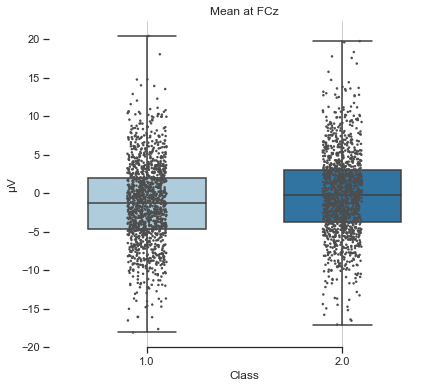

In [203]:
sns.set_theme(style="ticks")
f, ax = plt.subplots(figsize=(7, 6))

# Plot the orbital period with horizontal boxes
group_var = 'rp_class'
val_var = 'FCz'

F1 = sns.boxplot(x=group_var, y=val_var, data=win_eeg_mean,
              whis=[0, 100], width=.6, palette='Paired')
F1.set(title='Mean at '+ val_var)

    # Add in points to show each observation
sns.stripplot(x=group_var, y=val_var, data=win_eeg_mean,
              size=2.5, color=".3", linewidth=0)

# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set(ylabel='\u03bcV', xlabel='Class')
sns.despine(trim=True, left=True)

<font size="4">    <b>Linear Discriminent Analysis</b>

<font size="3">    <b>EEG</b>

In [29]:
Xeeg = df_eeg.iloc[:,2:].values
yeeg = np.asarray(df_eeg['rp_class'])

clf_eeg = LDA(solver='lsqr', shrinkage='auto')

clf_eeg.fit(Xeeg, yeeg)

# splits data randomly in n=folds 
kfolds = KFold(n_splits=10, random_state=1, shuffle=True) 

cv_results = cross_val_score(clf_eeg, Xeeg, yeeg, cv=kfolds)
cv_average = cv_results.mean()
st_deviation = cv_results.std()
print(cv_average)
print(st_deviation)
pred_y_eeg = cross_val_predict(clf_eeg, Xeeg, yeeg, cv=kfolds)

0.6666666666666666
0.07590333900710813


<font size="3">    <b>EMG</b>

In [315]:
Xemg = df_emg.iloc[:,2:].values
yemg = np.asarray(df_emg['rp_class'])

clf_emg = LDA(solver='lsqr', shrinkage='auto')

clf_emg.fit(Xemg, yemg)

# splits data randomly in n=folds 
kfolds = KFold(n_splits=10, random_state=1, shuffle=True) 

cv_results = cross_val_score(clf_emg, Xemg, yemg, cv=kfolds)
cv_average = cv_results.mean()
st_deviation = cv_results.std()
print(cv_average)
print(st_deviation)
pred_y_emg = cross_val_predict(clf_emg, Xemg, yemg, cv=kfolds)

0.8111111111111111
0.111665284679121


<font size="3">    <b>EEG - EMG</b>

In [316]:
X_eeg_emg = df_eeg_emg.iloc[:,2:].values
y_eeg_emg = np.asarray(df_emg['rp_class'])

clf_eeg_emg = LDA(solver='lsqr', shrinkage='auto')

clf_eeg_emg.fit(X_eeg_emg, y_eeg_emg)

# splits data randomly in n=folds 
kfolds = KFold(n_splits=10, random_state=1, shuffle=True) 

cv_results = cross_val_score(clf_eeg_emg, X_eeg_emg, y_eeg_emg, cv=kfolds)
cv_average = cv_results.mean()
st_deviation = cv_results.std()
print(cv_average)
print(st_deviation)
pred_y_eeg_emg = cross_val_predict(clf_eeg_emg, X_eeg_emg, y_eeg_emg, cv=kfolds)

0.8
0.06869347033700521


<font size="3">    <b>Classification metrics - EEG</b>

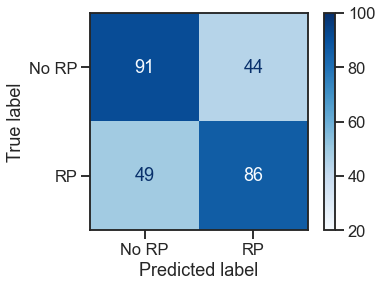

              precision    recall  f1-score   support

       No RP       0.65      0.67      0.66       135
          RP       0.66      0.64      0.65       135

    accuracy                           0.66       270
   macro avg       0.66      0.66      0.66       270
weighted avg       0.66      0.66      0.66       270



In [20]:
cm_eeg = confusion_matrix(y_true=yeeg, y_pred=pred_y_eeg)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_eeg, display_labels=["No RP", "RP"])
disp = disp.plot(cmap=plt.cm.Blues)
disp.ax_.get_images()[0].set_clim(20, 100)
plt.show()
print(classification_report(y_true=yeeg, 
                                y_pred=pred_y_eeg, 
                                target_names=["No RP", "RP"]))

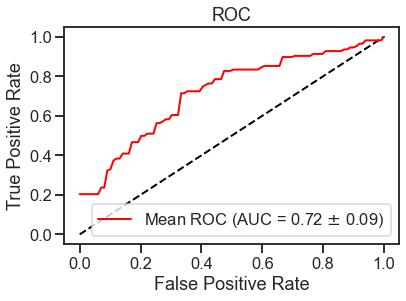

In [21]:
tprs = []
aucs = []
mean_fpr = np.linspace(0,1,100)
i = 1
for train,test in kfolds.split(Xeeg,yeeg):
    prediction = clf_eeg.fit(Xeeg[train],yeeg[train]).predict_proba(Xeeg[test])
    fpr, tpr, t = roc_curve(yeeg[test], prediction[:, 1], pos_label=2.0)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    i= i+1

plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='red',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),lw=2, alpha=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")

plt.show()

<font size="3">    <b>Classification metrics - EMG</b>

              precision    recall  f1-score   support

       No RP       0.95      0.66      0.78       135
          RP       0.74      0.96      0.84       135

    accuracy                           0.81       270
   macro avg       0.84      0.81      0.81       270
weighted avg       0.84      0.81      0.81       270



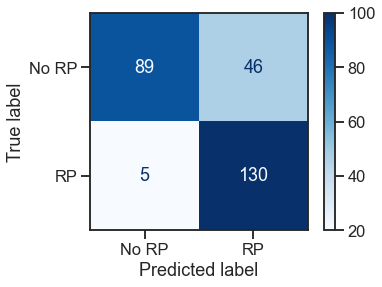

In [227]:
cm_emg = confusion_matrix(y_true=yemg, y_pred=pred_y_emg)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_emg, display_labels=["No RP", "RP"])
disp = disp.plot(cmap=plt.cm.Blues)
disp.ax_.get_images()[0].set_clim(20, 100)
print(classification_report(y_true=yemg, 
                                y_pred=pred_y_emg, 
                                target_names=["No RP", "RP"]))

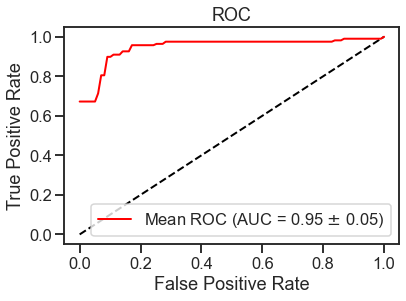

In [263]:
tprs = []
aucs = []
mean_fpr = np.linspace(0,1,100)
i = 1
for train,test in kfolds.split(Xemg,yemg):
    prediction = clf_emg.fit(Xemg[train],yemg[train]).predict_proba(Xemg[test])
    fpr, tpr, t = roc_curve(yemg[test], prediction[:, 1], pos_label=2.0)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    i= i+1

plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='red',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),lw=2, alpha=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")

plt.show()

<font size="3">    <b>Classification metrics - EEG-EMG</b>

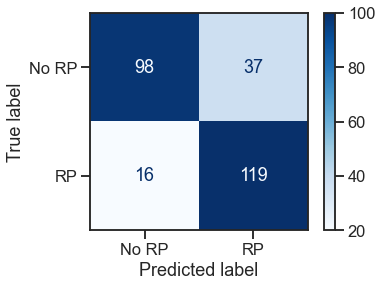

              precision    recall  f1-score   support

       No RP       0.86      0.73      0.79       135
          RP       0.76      0.88      0.82       135

    accuracy                           0.80       270
   macro avg       0.81      0.80      0.80       270
weighted avg       0.81      0.80      0.80       270



In [228]:
cm_eeg_emg = confusion_matrix(y_true=y_eeg_emg, y_pred=pred_y_eeg_emg)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_eeg_emg, display_labels=["No RP", "RP"])
disp = disp.plot(cmap=plt.cm.Blues)
disp.ax_.get_images()[0].set_clim(20, 100)
plt.show()
print(classification_report(y_true=y_eeg_emg, 
                                y_pred=pred_y_eeg_emg, 
                                target_names=["No RP", "RP"]))

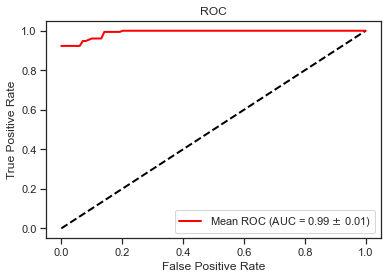

In [23]:
tprs = []
aucs = []
mean_fpr = np.linspace(0,1,100)
i = 1
for train,test in kfolds.split(X_eeg_emg,y_eeg_emg):
    prediction = clf_eeg_emg.fit(X_eeg_emg[train],y_eeg_emg[train]).predict_proba(X_eeg_emg[test])
    fpr, tpr, t = roc_curve(y_eeg_emg[test], prediction[:, 1], pos_label=2.0)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    i= i+1

plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='red',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),lw=2, alpha=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")

plt.show()

<font size="5">     <b>II. Time serie representation (only done for EEG yet)</b>

Test the previously trained classifier on sliding windows over time.
Rather than testing the classifier on the whole stream of data, I will test it only on the interval [-2, 1] which should be enough, it would then speed up the processing delay.

This includes the following steps: Time interest definition - Baseline correction - Features extraction - Probability calculation - DataFrame and plot

<font size="3" color='red'>    <b>Load the data and keep 20 best EEG</b>

In [253]:
pathe = '/Users/willy/Documents/GitHub/2021-fastReach/data/study/eeglab2python/11/\eeg.csv'
pathm = '/Users/willy/Documents/GitHub/2021-fastReach/data/study/eeglab2python/11/\motion.csv'
pathchan = '/Users/willy/Documents/GitHub/2021-fastReach/data/study/eeglab2python/11/\chans_rp-win_-1-0.csv'
move = pd.read_csv('/Users/willy/Documents/GitHub/2021-fastReach/data/study/eeglab2python/11/\motion_onset_event_latencies.csv', header = None)
move = move.values[0]

chan = pd.read_csv(pathchan, header=None)
eeg = pd.read_csv(pathe, header=None) # , dtype='float16'
velocity = pd.read_csv(pathm, header=None) # , dtype='float16'

# Select the best chans from the csv file to filter the eeg data
eeg_b = []
for i in chan.iloc[1:,0].astype(int)-1:  
    eeg_b.append(eeg.iloc[i,:])
eeg_b = pd.DataFrame(eeg_b)

<font size="3" color='blue'>    <b>Load the EMG data</b>

In [247]:
pathemg = '/Users/willy/Documents/GitHub/2021-fastReach/data/study/eeglab2python/11/\emg.csv'
emg = pd.read_csv(pathemg, header=None) # , dtype='float16'
emg.iloc[1,:] = emg.iloc[1,:] + 0.270
emg.iloc[0,:] = emg.iloc[0,:] - 0.009

<font size="3" color='red'>    <b>Extract the time frame of interest around the movement onset</b>

In [254]:
# Number of sample before and after movement onset
b_onset = 2000
a_onset = 1000
onset = move[:-1] # Adjust according to the number of onset we want to consider

# Extract this for the velocity
actual_velocity = np.zeros((len(onset), (b_onset + a_onset)))

# For EEG Let's create a matrix with row = epoch, columns = epoch duration and 3D = nb_chan
epoch = np.zeros((len(onset), (b_onset + a_onset), eeg_b.shape[0]))

for k in range(len(onset)):
   
    for j in range(eeg_b.shape[0]):
    
        epoch[k, 0:(b_onset + a_onset), j] = eeg_b.iloc[j, onset[k]-b_onset:onset[k]+a_onset]
       
        actual_velocity[k, :] = velocity.iloc[0, onset[k]-b_onset:onset[k]+a_onset]

<font size="3" color='blue'>    <b>Same for EMG</b>

In [248]:
# Number of sample before and after movement onset
b_onset = 2000
a_onset = 1000
onset = move[:-1] # Adjust according to the number of onset we want to consider

# Extract this for the velocity
actual_velocity = np.zeros((len(onset), (b_onset + a_onset)))

emepoch = np.zeros((len(onset), (b_onset + a_onset), emg.shape[0]))

for k in range(len(onset)):
   
    for j in range(emg.shape[0]):
    
        emepoch[k, 0:(b_onset + a_onset), j] = emg.iloc[j, onset[k]-b_onset:onset[k]+a_onset]
        
        actual_velocity[k, :] = velocity.iloc[0, onset[k]-b_onset:onset[k]+a_onset]

<font size="3" color='red'>    <b>Baseline correction: I think this messes up the final result</b>

In [255]:
#Try base line correction at the beginning of the epoch only, and each 250 trial as well
epoch_cor = np.zeros((epoch.shape))

for k in range(len(onset)):
    
    for j in range(eeg_b.shape[0]):
        
        for i in range((b_onset+a_onset)//250):
            
            epoch_cor[k, (250*i):250+(250*i), j] = epoch[k, (250*i):250+(250*i), j] - epoch[k, 250*i, j]

<font size="3" color='red'>    <b>EEG Feature extraction</b>

In [256]:
# (i and j) Extract the feature of size win_eeg 10 times per window on each channel. Each window is 250 samples.
# (l) Slide the window by x samples and repeat the extraction.
# (k) Switch to the next onset and repeat the process
# Output 'feat' with dim1 = onsets, dim2 = features, dim3 = number of windows

fs = 250
nb_feat = fs//win_eeg
sld_size = 1

feat = np.zeros((len(epoch_cor), nb_feat*epoch_cor.shape[2], (epoch_cor.shape[1]//sld_size) - fs + sld_size))

for k in range(len(epoch_cor)):             # Onset index
    for l in range(feat.shape[2]):          # Window index
        for j in range(epoch_cor.shape[2]): # Channel index
            for i in range(nb_feat):        # Feature index
                feat[k, i+10*j, l] = np.mean(epoch_cor[k, (win_eeg*i)+(sld_size*l):win_eeg+(win_eeg*i)+(sld_size*l), j])

<font size="3" color='blue'>    <b>Same for EMG</b>

In [249]:
# win_emg is actually = fs. What we will do is extracting the features once per window instead of 10 times like with EEG
# (j) Extract the feature once per channel
# (l) Slide the window by x samples and repeat the extraction.
# (k) Switch to the next onset and repeat the process
fs = 250
sld_size = 1

feat_emg = np.zeros((len(emepoch), df_emg.shape[1]-2, (emepoch.shape[1]//sld_size) - fs + sld_size))

for k in range(len(emepoch)):               # Onset index
    for l in range(feat_emg.shape[2]):      # Window index
        for j in range(emepoch.shape[2]):   # Channel index
            for i in range(len(feat_list)): # Feature index
                feat_emg[k, i+(5*j), l] = np.apply_along_axis(feat_list[i], 0, 
                                                                    emepoch[k, (sld_size*l) : fs + (sld_size*l), j])

In [311]:
feat_emg.shape

(149, 10, 2751)

<font size="3" color='purple'>    <b>Merge for EEG_EMG</b>

In [312]:
feat_eeg_emg = np. concatenate((feat, feat_emg), axis=1)

In [313]:
feat_eeg_emg.shape

(149, 210, 2751)

<font size="3" color='red'>    <b>Probability extraction</b>

In [257]:
# Calculate the probability of predicting an RP based on the EEG classifier previously trained.
# Let's output a matrix with Dim1 = onset and Dim2 = number of windows

proba = np.zeros((feat.shape[0], feat.shape[2]))

for k in range(len(epoch_cor)):
    
    for l in range(feat.shape[2]):
        
        proba[k, l] = clf_eeg.predict_proba(feat[k, :, l].reshape(1, -1))[0][1]

<font size="3" color='blue'>    <b>Same for EMG</b>

In [250]:
proba_emg = np.zeros((feat_emg.shape[0], feat_emg.shape[2]))

for k in range(len(emepoch)):
    
    for l in range(feat_emg.shape[2]):
        
        proba_emg[k, l] = clf_emg.predict_proba(feat_emg[k, :, l].reshape(1, -1))[0][1]

<font size="3" color='purple'>    <b>Same for EEG_EMG</b>

In [318]:
proba_eeg_emg = np.zeros((feat_eeg_emg.shape[0], feat_eeg_emg.shape[2]))

for k in range(len(emepoch)):
    
    for l in range(feat_eeg_emg.shape[2]):
        
        proba_eeg_emg[k, l] = clf_eeg_emg.predict_proba(feat_eeg_emg[k, :, l].reshape(1, -1))[0][1]

<font size="3" color='red'>    <b>Final DataFrame and representation</b>

In [299]:
# The objective is to represent the probability of RP prediction on the a certain interval of time around the movement onset.
# So let's build a data frame with the following columns: ['Time', 'Velocity', 'Probability']
time = np.arange(-b_onset, proba.shape[1] - b_onset)/1000
m_time = np.tile(time, (1, len(epoch_cor))).transpose()
f_time = np.reshape(m_time, len(m_time))

f_proba = np.reshape(proba, len(f_time))

m_velocity = actual_velocity[:, :proba.shape[1]]
f_velocity = np.reshape(m_velocity, len(f_time))

f_data = np.zeros((len(f_time), 3))
f_data[:,0] = f_time
f_data[:,1] = f_velocity * 1000
f_data[:,2] = f_proba
final = pd.DataFrame(f_data, columns=['Time', 'Velocity', 'Probability'])
final

,Time,Velocity,Probability
0,-2.000,0.007374,0.993285
1,-1.999,0.006945,0.991529
2,-1.998,0.006947,0.990116
3,-1.997,0.007485,0.988491
4,-1.996,0.007891,0.987115
...,...,...,...
409894,0.746,0.005464,0.756420
409895,0.747,0.007906,0.764143
409896,0.748,0.010623,0.784126
409897,0.749,0.013093,0.821098


In [292]:
#fin_prob = np.zeros((2751))

#for j in range(2751):
#    y_prob = 0
#    n_prob = 0
#    
#    for i in range(len(final)//2751):
#     
#        if final['Probability'][j+2751*i] > 0.5:
#            y_prob+=1   
#        else:
#            n_prob+=1
            
#    fin_prob[j]=(y_prob/(n_prob+y_prob))*100
#n = plt.plot(fin_prob)
#plt.ylim((0,1))

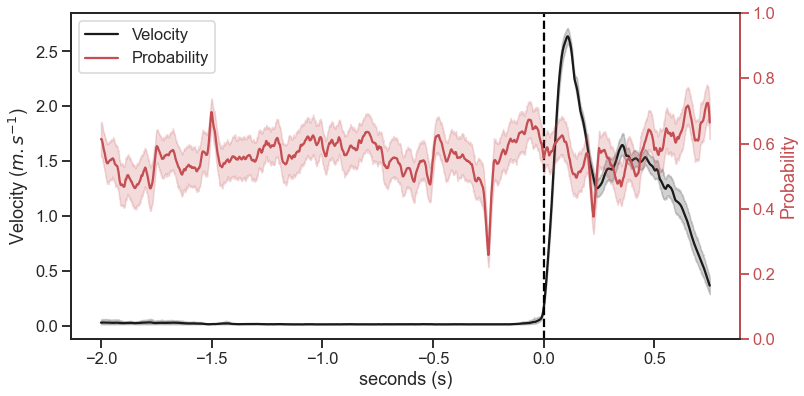

In [306]:
figure(figsize=(12, 6))

# Velocity
sns.set_theme(context='talk', style='ticks')
ep_move = sns.lineplot(data=final, x='Time', y='Velocity', color='k', legend=False)

ep_move.set(xlabel='seconds (s)', ylabel="Velocity ($m.s^{-1}$)")

# Movement onset
plt.axvline(0, color='black', label = 'onset', linestyle ='--')

# Probability
ax2 = plt.twinx()
ax2.set_ylabel('Probability', color='r')
ax2.spines['right'].set_color('r')
ax2.tick_params(axis='y', colors='r')
ep_prob = sns.lineplot(data=final, x='Time', y='Probability', ax=ax2, color='r', legend=False)
plt.ylim((0,1))
# legend
ep_prob.legend(loc='upper left', handles=[Line2D([], [], marker='_', color="k", label='Velocity'), 
                                          Line2D([], [], marker='_', color="r", label='Probability')])

<font size="3" color='blue'>    <b>Same for EMG</b>

In [297]:
# The objective is to represent the probability of RP prediction on the a certain interval of time around the movement onset.
# So let's build a data frame with the following columns: ['Time', 'Velocity', 'Probability']
time = np.arange(-b_onset, proba_emg.shape[1] - b_onset)/1000
m_time = np.tile(time, (1, len(emepoch))).transpose()
f_time = np.reshape(m_time, len(m_time))

f_proba_emg = np.reshape(proba_emg, len(f_time))

m_velocity = actual_velocity[:, :proba_emg.shape[1]]
f_velocity = np.reshape(m_velocity, len(f_time))

f_data_emg = np.zeros((len(f_time), 3))
f_data_emg[:,0] = f_time
f_data_emg[:,1] = f_velocity * 1000
f_data_emg[:,2] = f_proba_emg
final_emg = pd.DataFrame(f_data_emg, columns=['Time', 'Velocity', 'Probability'])
final_emg

,Time,Velocity,Probability
0,-2.000,0.007374,0.653023
1,-1.999,0.006945,0.653043
2,-1.998,0.006947,0.653178
3,-1.997,0.007485,0.653206
4,-1.996,0.007891,0.653202
...,...,...,...
409894,0.746,0.005464,0.035121
409895,0.747,0.007906,0.035238
409896,0.748,0.010623,0.035393
409897,0.749,0.013093,0.035490


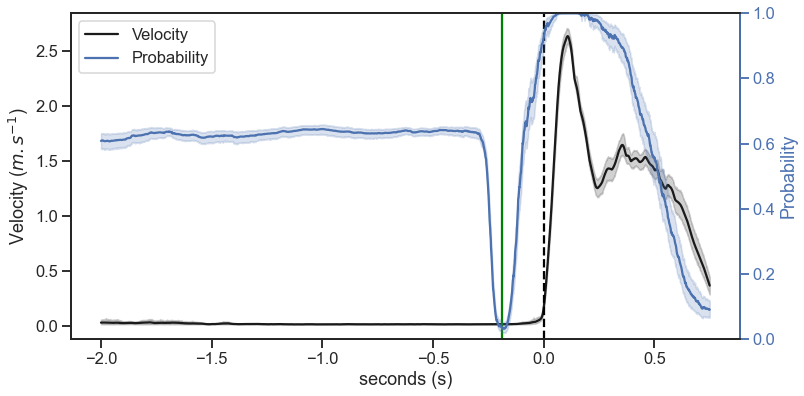

In [345]:
figure(figsize=(12, 6))

# Velocity
sns.set_theme(context='talk', style='ticks')
ep_move = sns.lineplot(data=final_emg, x='Time', y='Velocity', color='k', legend=False)

ep_move.set(xlabel='seconds (s)', ylabel="Velocity ($m.s^{-1}$)")

# Movement onset
plt.axvline(0, color='black', label = 'onset', linestyle ='--')

# Detection onset
plt.axvline(final_emg['Time'][np.argmin(final_emg.groupby(['Time'])['Probability'].mean())],
            color='green', label = 'onset')

# Probability
ax2 = plt.twinx()
ax2.set_ylabel('Probability', color='b')
ax2.spines['right'].set_color('b')
ax2.tick_params(axis='y', colors='b')
ep_prob = sns.lineplot(data=final_emg, x='Time', y='Probability', ax=ax2, color='b', legend=False)
plt.ylim((0,1))

# legend
ep_prob.legend(loc='upper left', handles=[Line2D([], [], marker='_', color="k", label='Velocity'), 
                                          Line2D([], [], marker='_', color="b", label='Probability')])

<font size="3" color='purple'>    <b>Same for EEG_EMG</b>

In [319]:
# The objective is to represent the probability of RP prediction on the a certain interval of time around the movement onset.
# So let's build a data frame with the following columns: ['Time', 'Velocity', 'Probability']
time = np.arange(-b_onset, proba_eeg_emg.shape[1] - b_onset)/1000
m_time = np.tile(time, (1, len(epoch_cor))).transpose()
f_time = np.reshape(m_time, len(m_time))

f_proba_eeg_emg = np.reshape(proba_eeg_emg, len(f_time))

m_velocity = actual_velocity[:, :proba_eeg_emg.shape[1]]
f_velocity = np.reshape(m_velocity, len(f_time))

f_data_eeg_emg = np.zeros((len(f_time), 3))
f_data_eeg_emg[:,0] = f_time
f_data_eeg_emg[:,1] = f_velocity * 1000
f_data_eeg_emg[:,2] = f_proba_eeg_emg
final_eeg_emg = pd.DataFrame(f_data_eeg_emg, columns=['Time', 'Velocity', 'Probability'])
final_eeg_emg

,Time,Velocity,Probability
0,-2.000,0.007374,0.998230
1,-1.999,0.006945,0.997741
2,-1.998,0.006947,0.997353
3,-1.997,0.007485,0.996887
4,-1.996,0.007891,0.996723
...,...,...,...
409894,0.746,0.005464,0.025741
409895,0.747,0.007906,0.020093
409896,0.748,0.010623,0.016563
409897,0.749,0.013093,0.016216


In [333]:
np.argmin(final_eeg_emg.groupby(['Time'])['Probability'].mean())

1789

In [334]:
final_eeg_emg['Time'][np.argmin(final_eeg_emg.groupby(['Time'])['Probability'].mean())]

-0.211

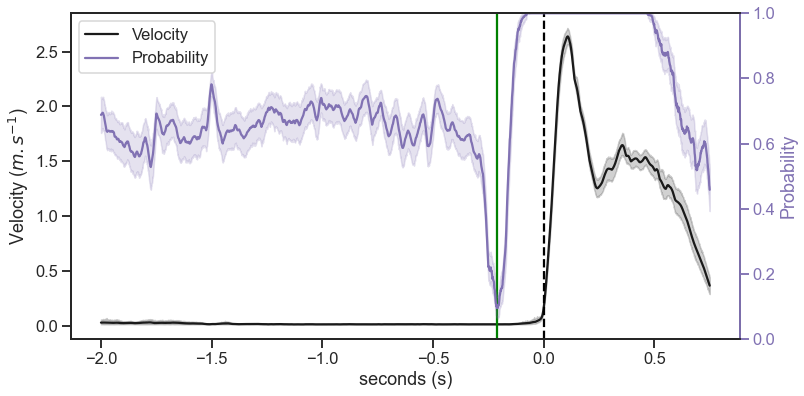

In [336]:
figure(figsize=(12, 6))

# Velocity
sns.set_theme(context='talk', style='ticks')
ep_move = sns.lineplot(data=final_eeg_emg, x='Time', y='Velocity', color='k', legend=False)

ep_move.set(xlabel='seconds (s)', ylabel="Velocity ($m.s^{-1}$)")

# Movement onset
plt.axvline(0, color='black', label = 'onset', linestyle ='--')

# Detection onset
plt.axvline(final_eeg_emg['Time'][np.argmin(final_eeg_emg.groupby(['Time'])['Probability'].mean())],
            color='green', label = 'onset')

# Probability
ax2 = plt.twinx()
ax2.set_ylabel('Probability', color='m')
ax2.spines['right'].set_color('m')
ax2.tick_params(axis='y', colors='m')
ep_prob = sns.lineplot(data=final_eeg_emg, x='Time', y='Probability', ax=ax2, color='m', legend=False)
plt.ylim((0,1))

# legend
ep_prob.legend(loc='upper left', handles=[Line2D([], [], marker='_', color="k", label='Velocity'), 
                                          Line2D([], [], marker='_', color="m", label='Probability')])

<font size="3" color='purple'>    <b>EEG and EMG superposition</b>

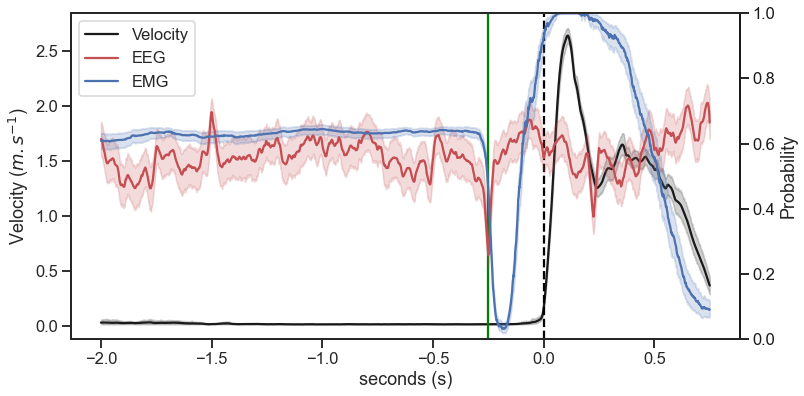

In [347]:
figure(figsize=(12, 6))

# Velocity
sns.set_theme(context='talk', style='ticks')
ep_move = sns.lineplot(data=final, x='Time', y='Velocity', color='k', legend=False)

ep_move.set(xlabel='seconds (s)', ylabel="Velocity ($m.s^{-1}$)")

# Movement onset
plt.axvline(0, color='black', label = 'onset', linestyle ='--')

# Detection onset
plt.axvline(final['Time'][np.argmin(final.groupby(['Time'])['Probability'].mean())],
            color='green', label = 'onset')

# Probability EEG
ax2 = plt.twinx()
ax2.set_ylabel('Probability')
ax2.spines['right'].set_color('k')
ax2.tick_params(axis='y', colors='k')
ep_prob = sns.lineplot(data=final, x='Time', y='Probability', ax=ax2, color='r', legend=False)
plt.ylim((0,1))

# Probability
ep_prob_2 = sns.lineplot(data=final_emg, x='Time', y='Probability',ax=ax2, color='b', legend=False)
plt.ylim((0,1))

# legend
ep_prob.legend(loc='upper left', handles=[Line2D([], [], marker='_', color="k", label='Velocity'), 
                                          Line2D([], [], marker='_', color="r", label='EEG'),
                                          Line2D([], [], marker='_', color="b", label='EMG')])

<font size="3" color='red'>    <b>Other option for baseline correction, after the feature extraction:</b>

In [ ]:
#Correct the baseline after mean feature extraction, I think it should work that way
cor = np.zeros((a.shape[0], a.shape[1]))
for k in range(a.shape[0]):
    for j in range(eeg_b.shape[0]):
        cor[k, nb_feat * j:nb_feat + nb_feat * j] = a[k, nb_feat * j:nb_feat + nb_feat * j] - \
                                                                    eeg_b.iloc[j, k * sld_size]

#Repeat the values to fit the number of time and velocity samples
cor_ext = np.repeat(cor, sld_size, axis=0)

Accélérer le script, faire la même pour EMG. Essayer de refaire la même chose avec intention intervale [-500ms - 0s]